In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
def to_classlabel(z):
    return z.argmax(axis = 1)

In [3]:
def one_hot_encode(y):
    n_class = np.unique(y).shape[0]
    y_encode = np.zeros((y.shape[0], n_class))
    for idx, val in enumerate(y):
        y_encode[idx, val] = 1.0
    return y_encode


In [4]:
# Define Accuracy
def accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred) / len(y_true)
    return acc


In [5]:

class Softmax_Regression_AdamD():
    
    def __init__(self, lambda_param=0.01):
        self.theta = None
        self.lambda_param = lambda_param  # Parámetro de regularización L2
        
    def _softmax(self, Z):
        """Implementación manual de softmax con estabilidad numérica"""
        # Estabilidad numérica: restar el máximo para evitar overflow
        shiftZ = Z - np.max(Z, axis=1, keepdims=True)
        expZ = np.exp(shiftZ)
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def _loss(self, Y, h, theta):
        """Función de pérdida de entropía cruzada categórica con regularización L2"""
        epsilon = 1e-10  # Para evitar log(0)
        m = Y.shape[0]
        # Pérdida de entropía cruzada
        loss = -np.sum(Y * np.log(np.clip(h, epsilon, 1 - epsilon))) / m
        # Término de regularización L2 (excluir sesgo)
        reg_term = (self.lambda_param / (2 * m)) * np.sum(theta[1:, :]**2)
        return loss + reg_term

    def gradient(self, A, Y, h, theta):
        """Calcula el gradiente con regularización L2"""
        m = A.shape[0]
        grad = (1 / m) * A.T @ (h - Y)
        # Aplicar regularización solo a los pesos (no al sesgo)
        grad[1:, :] += (self.lambda_param / m) * theta[1:, :]
        return grad

    def fit(self, A, y, learning_rate=0.001, beta1=0.9, beta2=0.999, 
            epsilon=1e-8, epochs=100, batch_size=32, show_step=10, 
            stopping_threshold=1e-6, verbose=False):
        """
        Entrenamiento con optimizador AdamD
        
        Parámetros:
        A: Matriz de diseño
        y: Etiquetas
        learning_rate: Tasa de aprendizaje (alpha)
        beta1, beta2: Parámetros de momento
        epsilon: Constante de estabilidad numérica
        epochs: Número máximo de épocas
        batch_size: Tamaño del lote (1=online, len(y)=batch, otro=minilotes)
        show_step: Frecuencia para mostrar progreso
        stopping_threshold: Umbral para parada temprana
        verbose: Mostrar información durante el entrenamiento
        """
        # Convertir y a one-hot encoding
        Y = one_hot_encode(y)
        n_classes = Y.shape[1]
        n_features = A.shape[1]
        n_obs = A.shape[0]
        
        # Inicializar parámetros
        self.theta = np.random.randn(n_features, n_classes) * 0.01
        m = np.zeros_like(self.theta)  # Primer momento
        v = np.zeros_like(self.theta)  # Segundo momento
        t = 0  # Contador de pasos
        
        previous_loss = np.inf
        epoch_losses = []
        
        for epoch in range(epochs):
            # Barajar datos
            permutation = np.random.permutation(n_obs)
            A_shuffled = A[permutation]
            Y_shuffled = Y[permutation]
            
            epoch_loss = 0.0
            n_batches = n_obs // batch_size
            residual = n_obs % batch_size
            total_batches = n_batches + (1 if residual != 0 else 0)
            
            for batch_idx in range(total_batches):
                t += 1
                start = batch_idx * batch_size
                end = start + batch_size
                
                # Manejar el último lote si es más pequeño
                if batch_idx == total_batches - 1 and residual != 0:
                    end = start + residual
                
                A_batch = A_shuffled[start:end]
                Y_batch = Y_shuffled[start:end]
                
                # Calcular softmax y pérdida
                Z_batch = A_batch @ self.theta
                S_batch = self._softmax(Z_batch)
                loss_batch = self._loss(Y_batch, S_batch, self.theta)
                epoch_loss += loss_batch * len(Y_batch)
                
                # Calcular gradiente
                grad = self.gradient(A_batch, Y_batch, S_batch, self.theta)
                
                # Actualización AdamD
                m = beta1 * m + (1 - beta1) * grad
                v = beta2 * v + (1 - beta2) * (grad**2)
                
                # Calcular tasa de aprendizaje adaptativa
                alpha_t = learning_rate * np.sqrt(1 - beta2**t)
                
                # Actualizar parámetros
                self.theta -= alpha_t * m / (np.sqrt(v) + epsilon)
            
            # Pérdida promedio por muestra
            epoch_loss /= n_obs
            epoch_losses.append(epoch_loss)
            
            # Parada temprana
            if epoch > 0 and abs(previous_loss - epoch_loss) < stopping_threshold:
                if verbose:
                    print(f"Early stopping at epoch {epoch}")
                break
                
            previous_loss = epoch_loss
            
            if verbose and epoch % show_step == 0:
                print(f'Epoch: {epoch}, Loss: {epoch_loss:.6f}')
        
        return epoch_losses
                
    def predict(self, A):
        Z = A @ self.theta
        S = self._softmax(Z)
        return np.argmax(S, axis=1)

In [6]:


#  Cargar datos
try:
    # Intenta leer como archivo de texto
    data = np.loadtxt('cancer_dataset.dat', delimiter=',')
except:
    # Intenta leer como binario si falla
    data = np.fromfile('cancer_dataset.dat', dtype=np.float32)
    # Ajustar según la estructura de tus datos (30 características + 1 etiqueta)
    data = data.reshape((-1, 31))

In [7]:



# Procesamiento de datos
inputs = data[:, :-1]
targets = data[:, -1].astype(int)

In [8]:


# División de datos
x_train, x_test, y_train, y_test = train_test_split(
    inputs, targets, test_size=0.3, random_state=42
)


In [9]:
# Normalización
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [10]:


# Matrices de diseño
A_train = np.c_[np.ones(len(x_train)), x_train]
A_test = np.c_[np.ones(len(x_test)), x_test]

In [11]:
#online: 
lambda_param = 0.1  # Regularización L2
fit_params = {
    'learning_rate': 1e-2,
    'beta1': 0.9,
    'beta2': 0.999,
    'epsilon': 1e-8,
    'epochs': 300,
    'batch_size': 1,
    'show_step': 25,
    'stopping_threshold': 1e-4,
    'verbose': True
}

#minilote

# lambda_param = 0.01  # Regularización L2
# fit_params = {
#     'learning_rate': 1e-3,
#     'beta1': 0.9,
#     'beta2': 0.999,
#     'epsilon': 1e-8,
#     'epochs': 1000,
#     'batch_size': 256,
#     'show_step': 100,
#     'stopping_threshold': 1e-4,
#     'verbose': True
# }

#lote 
# lambda_param = 1.0  # Regularización L2
# fit_params = {
#     'learning_rate': 0.1,
#     'beta1': 0.9,
#     'beta2': 0.999,
#     'epsilon': 1e-8,
#     'epochs': 500,
#     'batch_size': len(y_train),
#     'show_step': 50,
#     'stopping_threshold': 1e-4,
#     'verbose': True
# }


In [12]:
# Entrenamiento del modelo

model = Softmax_Regression_AdamD(lambda_param=lambda_param)
loss_history = model.fit(A_train, y_train, **fit_params)




Epoch: 0, Loss: 0.140716
Epoch: 25, Loss: 0.115484
Early stopping at epoch 35


In [13]:

# Predicciones
train_pred = model.predict(A_train)
test_pred = model.predict(A_test)



In [14]:
print(f"Modo de aprendizaje: {'Online' if fit_params['batch_size'] == 1 else 'Batch completo' if fit_params['batch_size'] >= len(y_train) else 'Mini-lotes'}")
print(f"Tamaño de lote: {fit_params['batch_size']}")
print(f"Regularización L2: lambda={lambda_param}")
print(f"Épocas completadas: {len(loss_history)}/{fit_params['epochs']}")


Modo de aprendizaje: Online
Tamaño de lote: 1
Regularización L2: lambda=0.1
Épocas completadas: 36/300


In [15]:

# Resultados entrenamiento
print("\nResultados en conjunto de entrenamiento:")
print(f'Accuracy: {accuracy(y_train, train_pred):.4f}')
print("Matriz de confusión:")
print(confusion_matrix(y_train, train_pred))
print("\nReporte de clasificación:")
print(classification_report(y_train, train_pred))




Resultados en conjunto de entrenamiento:
Accuracy: 0.9959
Matriz de confusión:
[[326   2]
 [  0 161]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       328
           1       0.99      1.00      0.99       161

    accuracy                           1.00       489
   macro avg       0.99      1.00      1.00       489
weighted avg       1.00      1.00      1.00       489



In [16]:
# Resultados prueba
print("\nResultados en conjunto de prueba:")
print(f'Accuracy: {accuracy(y_test, test_pred):.4f}')
print("Matriz de confusión:")
print(confusion_matrix(y_test, test_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, test_pred))




Resultados en conjunto de prueba:
Accuracy: 0.9857
Matriz de confusión:
[[128   2]
 [  1  79]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       130
           1       0.98      0.99      0.98        80

    accuracy                           0.99       210
   macro avg       0.98      0.99      0.98       210
weighted avg       0.99      0.99      0.99       210



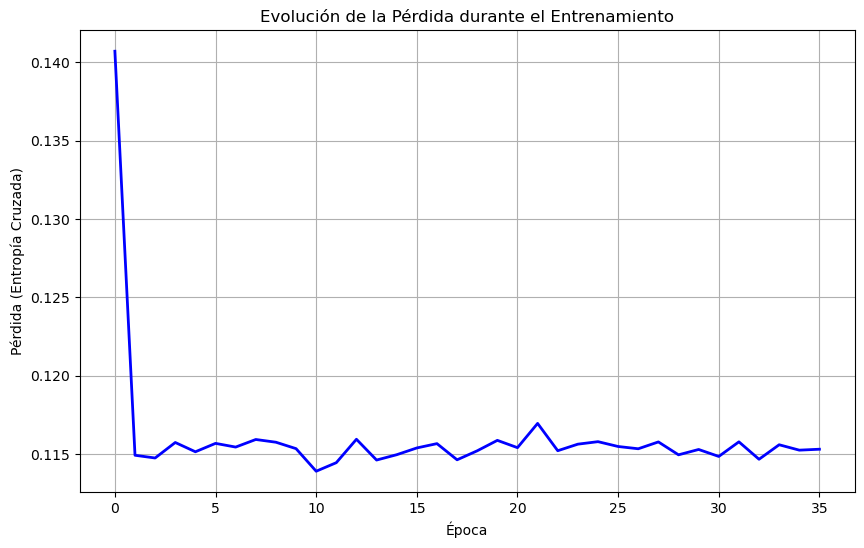

In [17]:

# Gráfica de pérdida
plt.figure(figsize=(10, 6))
plt.plot(loss_history, 'b-', linewidth=2)
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (Entropía Cruzada)')
plt.grid(True)
plt.show()